# Link Prediction : 7가지 = 동일한 커뮤니티 (그래프 전체), 다른 커뮤니티 (서로 다른 서브그래프들)
- [참고] https://brain-nim.tistory.com/m/76  

## 1. 하나의(동일한) community에서 링크를 예측하는 휴리스틱한 방법들 : Heuristics = CN, Jaccard, RA, AA, PA
- CN 에서 거리 2인 경로 구하는 과정만 추가되고, 이후의 계산은 모두 `networkx` 라이브러리 사용  
  
1. `CN (Common Neighbors)` : $CN(x,y)=|N(x)\cap N(y)|$  
  
2. `Jaccard Coefficient` : $J(x,y)=\frac{|N(x)\cap N(y)|}{|N(x)\cup N(y)|}$  
  
3. `RA (Resource Allocation)` : $RA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{|N(v)|}$  
  
4. `AA (Adamic-Adar Index)` : $AA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{\log |N(v)|}$  
  
5. `PA (Preferential Attachment Model, Barabasi Albert Model)` : $PA(x,y)=|N(x)||N(y)|$  

### 1-0. 데이터 만들기 -> 코라 데이터는 그래프 1개
#### 1-0-1. 예제 그래프 데이터 만들기 : Cora Data

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid#, CoraFull
import torch_geometric.transforms as T
import networkx as nx
import warnings
warnings.filterwarnings(action='ignore')
## Load Dataset
# load the Cora dataset
dataset = 'Cora'
path = os.path.join('../', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures()) 
data = dataset[0]
print(dataset.data)
print('------------------------------------------------------------------------------------------------------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()} -> i.e., no nodes not connected by edges')
print(f'Has self-loops: {data.has_self_loops()} -> i.e., no self-loops')
print(f'Is undirected: {data.is_undirected()} -> i.e., not directional')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
------------------------------------------------------------------------------------------------------------
Number of nodes: 2708
Number of edges: 10556
Has isolated nodes: False -> i.e., no nodes not connected by edges
Has self-loops: False -> i.e., no self-loops
Is undirected: True -> i.e., not directional


In [2]:
# import torch
# # Transfer data object to GPU.
# device = torch.device('cuda')
# data = data.to(device) # GPU 사용으로 변경

In [3]:
# ## 속성
# data.x ## 노드 특징 행렬 = [num_nodes, num_node_features]
# data.edge_index ## 그래프 연결성 = [2,  num_edges]
# data.edge_attr ## 엣지 특징 행렬 = [num_edges, num_edge_features]
# data.y ## 학습하고 싶은 대상(target), 그래프 레벨 -> [num_nodes,*], 노드 레벨 -> [1,*]
# data.pos ## 노드 위치 행렬 = [num_nodes, dimensions] 
# ## 함수
# data.keys ## 해당 속성 이름 = [edge_index, x]
# data.num_nodes ## 노드의 총 개수
# data.num_edges ## 엣지 총 개수
# data.contains_isolated_nodes() ## 고립된 노드 여부 확인
# data.contains_self_loops() ## 셀프 루프 포함 여부 확인
# data.is_directed() ## 그래프의 방향성 여부 확인

----------------------
#### 1-0-2. Cora 그래프 그리기
- 참고 : https://medium.com/mlearning-ai/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f  
  
- 실제 계산 : Cora subgraph 사용 -> 계산량 때문에 이 그래프로 유사도 계산 연습

(2, 10556)
Average node degree: 3.90
-------------------------------------------------------------------------------
edge example = (2,12)
[[   0    0    0    1    1    1    2    2    2    2    2    3]
 [ 633 1862 2582    2  652  654    1  332 1454 1666 1986 2544]]
node example = 14
[   0    1    2    3  332  633  652  654 1454 1666 1862 1986 2544 2582]


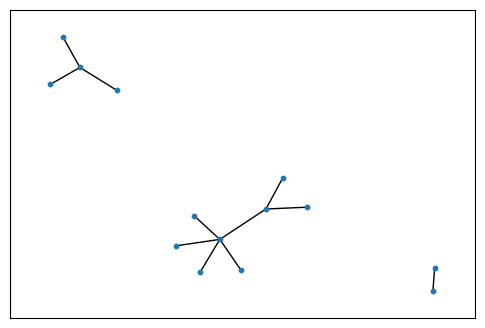

In [4]:
## Cora 부분그래프
edge_index = data.edge_index.numpy()
print(edge_index.shape)
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print('-------------------------------------------------------------------------------')
## Example : edge=12, node=14
edge_example = edge_index[:, np.where(edge_index[0]<4)[0]]
print('edge example = (%s,%s)' % edge_example.shape, edge_example, sep='\n')
node_example = np.unique(edge_example.flatten())
print('node example = %s' % node_example.shape, node_example, sep='\n')

plt.figure(figsize=(6, 4))
sub_G = nx.Graph()
sub_G.add_nodes_from(node_example)
sub_G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(sub_G, with_labels=False, node_size=10)

In [5]:
# import pandas as pd
# from torch_geometric.utils import to_networkx

# G = to_networkx(data, to_undirected=True)
# degrees = [val for (node, val) in G.degree()]
# display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
# print(len(degrees))
# print(sum(degrees))
# plt.figure(figsize=(10, 6))
# plt.hist(degrees, bins=50)
# plt.xlabel("node degree")
# plt.show()

- Cora graph

threshold 0.011821204285186553


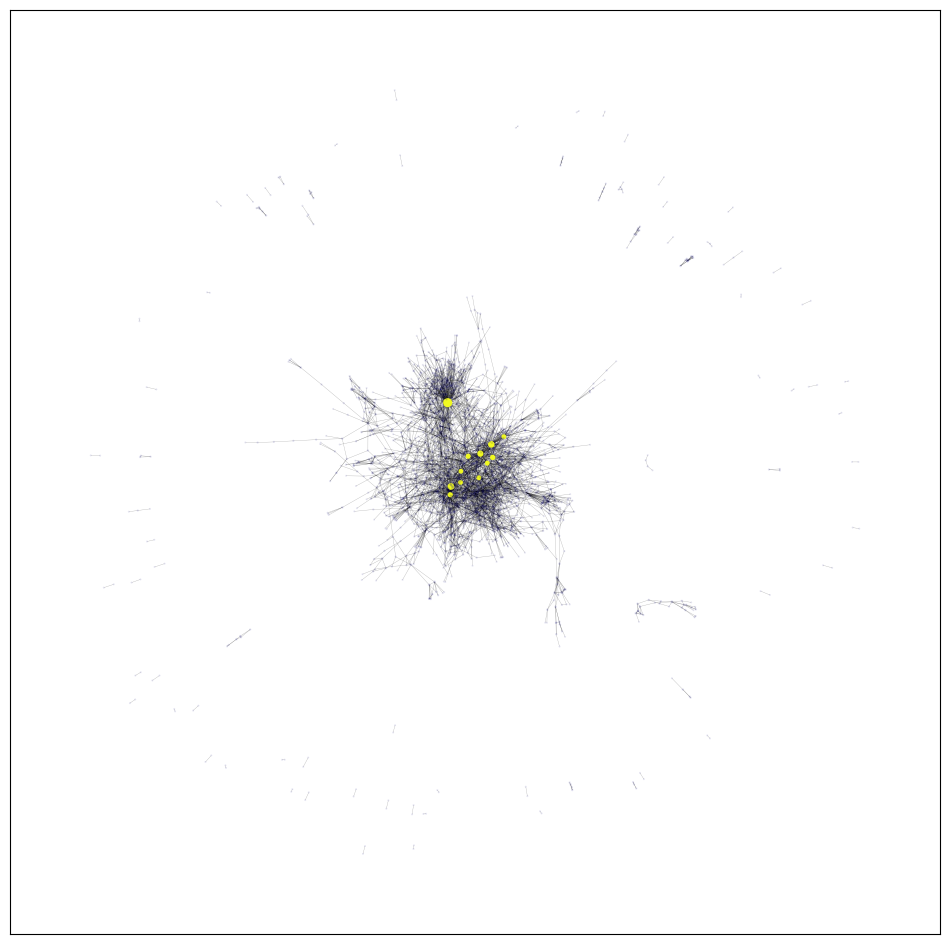

In [6]:
## Cora data nx.draw
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

-------------

### 1-1. `CN (Common Neighbors)` for (sub)Cora 
- example = subgraph, 계산량 너무 커서 pc 버벅거림  
- $CN(x,y)=|N(x)\cap N(y)|$  
    where $x,y$ : nodes and $N(x), N(y)$ : neighborhoods of $x,y$ (respectively)  
  
- 알고리즘 순서  
    a. 비연결 node pair 구하기  
  
    b. 거리 2인 경로 구하기  
    - 방법 : a 에서 구한 각 비연결 노드 pair에 대한 (1-hop) 이웃 노드를 거치면 거리 2인 경로  
    - `nx.common_neighbors(G, u, v)` where $G$ : undirected graph and $u,v$ : nodes  
    - https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.common_neighbors.html
  
    c. 각 node pair 마다 길이 2인 경로의 개수 세기

In [7]:
## 1-1. CN (Common Neighbors) 

#### 엣지 연결이 없는 노드쌍 구하기 :
non_edges = list(nx.non_edges(sub_G))
print(non_edges, len(non_edges), sep='\n')
print('--------------------------------------------------------------------------------------')

#### 길이 2인 경로 구하기 : 
CN = {}
for s,t in non_edges:
    print(s,t, list(nx.common_neighbors(sub_G,s,t))) 

[(0, 1), (0, 2), (0, 3), (0, 1986), (0, 1666), (0, 332), (0, 652), (0, 654), (0, 1454), (0, 2544), (1, 1986), (1, 1666), (1, 3), (1, 1862), (1, 332), (1, 1454), (1, 2544), (1, 2582), (1, 633), (2, 3), (2, 1862), (2, 652), (2, 654), (2, 2544), (2, 2582), (2, 633), (3, 1666), (3, 1986), (3, 1862), (3, 332), (3, 652), (3, 654), (3, 1454), (3, 2582), (3, 633), (1666, 1986), (1666, 1862), (1666, 332), (1666, 652), (1666, 654), (1666, 1454), (1666, 2544), (1666, 2582), (1666, 633), (1986, 1862), (1986, 332), (1986, 652), (1986, 654), (1986, 1454), (1986, 2544), (1986, 2582), (1986, 633), (1862, 652), (1862, 332), (1862, 654), (1862, 1454), (1862, 2544), (1862, 2582), (1862, 633), (332, 652), (332, 654), (332, 1454), (332, 2544), (332, 2582), (332, 633), (652, 1454), (652, 654), (652, 2544), (652, 2582), (652, 633), (654, 2544), (654, 633), (654, 1454), (654, 2582), (1454, 2544), (1454, 633), (1454, 2582), (2544, 633), (2544, 2582), (2582, 633)]
80
--------------------------------------------

In [8]:
## 1-1. CN (Common Neighbors) 
## 엣지 연결이 없는 노드쌍
non_edges = list(nx.non_edges(sub_G))
# print(non_edges)

# 공통이웃 수 count 딕셔너리 생성 : 길이 2인 경로 구하기
common_neighbors_count = {}
for n1,n2 in non_edges:
    common_neighbors_count[(n1, n2)] = len(list(nx.common_neighbors(sub_G, n1, n2)))
    # print(common_neighbors_count)
sorted(common_neighbors_count.items(), key=lambda x: x[1], reverse=True)

[((1, 1986), 1),
 ((1, 1666), 1),
 ((1, 332), 1),
 ((1, 1454), 1),
 ((2, 652), 1),
 ((2, 654), 1),
 ((1666, 1986), 1),
 ((1666, 332), 1),
 ((1666, 1454), 1),
 ((1986, 332), 1),
 ((1986, 1454), 1),
 ((1862, 2582), 1),
 ((1862, 633), 1),
 ((332, 1454), 1),
 ((652, 654), 1),
 ((2582, 633), 1),
 ((0, 1), 0),
 ((0, 2), 0),
 ((0, 3), 0),
 ((0, 1986), 0),
 ((0, 1666), 0),
 ((0, 332), 0),
 ((0, 652), 0),
 ((0, 654), 0),
 ((0, 1454), 0),
 ((0, 2544), 0),
 ((1, 3), 0),
 ((1, 1862), 0),
 ((1, 2544), 0),
 ((1, 2582), 0),
 ((1, 633), 0),
 ((2, 3), 0),
 ((2, 1862), 0),
 ((2, 2544), 0),
 ((2, 2582), 0),
 ((2, 633), 0),
 ((3, 1666), 0),
 ((3, 1986), 0),
 ((3, 1862), 0),
 ((3, 332), 0),
 ((3, 652), 0),
 ((3, 654), 0),
 ((3, 1454), 0),
 ((3, 2582), 0),
 ((3, 633), 0),
 ((1666, 1862), 0),
 ((1666, 652), 0),
 ((1666, 654), 0),
 ((1666, 2544), 0),
 ((1666, 2582), 0),
 ((1666, 633), 0),
 ((1986, 1862), 0),
 ((1986, 652), 0),
 ((1986, 654), 0),
 ((1986, 2544), 0),
 ((1986, 2582), 0),
 ((1986, 633), 0),
 ((18

### 1-2. `Jaccard Coefficient (- index, - similarity)`  
- $J(x,y)=\frac{|N(x)\cap N(y)|}{|N(x)\cup N(y)|}$  
  
- `nx.jaccard_coefficient(G, ebunch=None)`  where `ebunch` : iterable of node pairs, optional (default = None)  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html#networkx.algorithms.link_prediction.jaccard_coefficient 

In [9]:
## (2) Jaccard
jaccard = list(nx.jaccard_coefficient(sub_G))
print('unsorted jaccard index :\n%s' % jaccard)
jaccard = sorted(jaccard, key=lambda x: x[2], reverse=True)  
print('---------------------------------------------------')
# jaccard.sort(key=lambda x: x[2], reverse=True)  
# print('Jaccard = %s' % jaccard)
for u,v,j in jaccard:
    print(f"({u},{v}) -> {j}")#:.8f}")

unsorted jaccard index :
[(0, 1, 0.0), (0, 2, 0.0), (0, 3, 0.0), (0, 1986, 0.0), (0, 1666, 0.0), (0, 332, 0.0), (0, 652, 0.0), (0, 654, 0.0), (0, 1454, 0.0), (0, 2544, 0.0), (1, 1986, 0.3333333333333333), (1, 1666, 0.3333333333333333), (1, 3, 0.0), (1, 1862, 0.0), (1, 332, 0.3333333333333333), (1, 1454, 0.3333333333333333), (1, 2544, 0.0), (1, 2582, 0.0), (1, 633, 0.0), (2, 3, 0.0), (2, 1862, 0.0), (2, 652, 0.2), (2, 654, 0.2), (2, 2544, 0.0), (2, 2582, 0.0), (2, 633, 0.0), (3, 1666, 0.0), (3, 1986, 0.0), (3, 1862, 0.0), (3, 332, 0.0), (3, 652, 0.0), (3, 654, 0.0), (3, 1454, 0.0), (3, 2582, 0.0), (3, 633, 0.0), (1666, 1986, 1.0), (1666, 1862, 0.0), (1666, 332, 1.0), (1666, 652, 0.0), (1666, 654, 0.0), (1666, 1454, 1.0), (1666, 2544, 0.0), (1666, 2582, 0.0), (1666, 633, 0.0), (1986, 1862, 0.0), (1986, 332, 1.0), (1986, 652, 0.0), (1986, 654, 0.0), (1986, 1454, 1.0), (1986, 2544, 0.0), (1986, 2582, 0.0), (1986, 633, 0.0), (1862, 652, 0.0), (1862, 332, 0.0), (1862, 654, 0.0), (1862, 1454,

### 1-3. `RA, Resource Allocation (자원할당)`  
- $RA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{|N(v)|}$  
  
- `resource_allocation_index(G, ebunch=None)`
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html

In [10]:
## (3) RA, 자원 할당
resource = list(nx.resource_allocation_index(sub_G))
resource = sorted(resource, key=lambda x: x[2], reverse=True)
for u,v,r in resource:
    print(f"({u},{v}) -> {r}")

(2,652) -> 0.3333333333333333
(2,654) -> 0.3333333333333333
(1862,2582) -> 0.3333333333333333
(1862,633) -> 0.3333333333333333
(652,654) -> 0.3333333333333333
(2582,633) -> 0.3333333333333333
(1,1986) -> 0.2
(1,1666) -> 0.2
(1,332) -> 0.2
(1,1454) -> 0.2
(1666,1986) -> 0.2
(1666,332) -> 0.2
(1666,1454) -> 0.2
(1986,332) -> 0.2
(1986,1454) -> 0.2
(332,1454) -> 0.2
(0,1) -> 0
(0,2) -> 0
(0,3) -> 0
(0,1986) -> 0
(0,1666) -> 0
(0,332) -> 0
(0,652) -> 0
(0,654) -> 0
(0,1454) -> 0
(0,2544) -> 0
(1,3) -> 0
(1,1862) -> 0
(1,2544) -> 0
(1,2582) -> 0
(1,633) -> 0
(2,3) -> 0
(2,1862) -> 0
(2,2544) -> 0
(2,2582) -> 0
(2,633) -> 0
(3,1666) -> 0
(3,1986) -> 0
(3,1862) -> 0
(3,332) -> 0
(3,652) -> 0
(3,654) -> 0
(3,1454) -> 0
(3,2582) -> 0
(3,633) -> 0
(1666,1862) -> 0
(1666,652) -> 0
(1666,654) -> 0
(1666,2544) -> 0
(1666,2582) -> 0
(1666,633) -> 0
(1986,1862) -> 0
(1986,652) -> 0
(1986,654) -> 0
(1986,2544) -> 0
(1986,2582) -> 0
(1986,633) -> 0
(1862,652) -> 0
(1862,332) -> 0
(1862,654) -> 0
(1862,

### 1-4. `AA, Adamic Adar`  
- $AA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{\log|N(v)|}$  
  
- `resource_allocation_index(G, ebunch=None)`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html#networkx.algorithms.link_prediction.resource_allocation_index

In [11]:
## AA
aa = list(nx.adamic_adar_index(sub_G))
aa = sorted(aa, key=lambda x: x[2], reverse=True)
for u,v,a in aa:
    print(f"({u},{v}) -> {a}")

(2,652) -> 0.9102392266268373
(2,654) -> 0.9102392266268373
(1862,2582) -> 0.9102392266268373
(1862,633) -> 0.9102392266268373
(652,654) -> 0.9102392266268373
(2582,633) -> 0.9102392266268373
(1,1986) -> 0.6213349345596119
(1,1666) -> 0.6213349345596119
(1,332) -> 0.6213349345596119
(1,1454) -> 0.6213349345596119
(1666,1986) -> 0.6213349345596119
(1666,332) -> 0.6213349345596119
(1666,1454) -> 0.6213349345596119
(1986,332) -> 0.6213349345596119
(1986,1454) -> 0.6213349345596119
(332,1454) -> 0.6213349345596119
(0,1) -> 0
(0,2) -> 0
(0,3) -> 0
(0,1986) -> 0
(0,1666) -> 0
(0,332) -> 0
(0,652) -> 0
(0,654) -> 0
(0,1454) -> 0
(0,2544) -> 0
(1,3) -> 0
(1,1862) -> 0
(1,2544) -> 0
(1,2582) -> 0
(1,633) -> 0
(2,3) -> 0
(2,1862) -> 0
(2,2544) -> 0
(2,2582) -> 0
(2,633) -> 0
(3,1666) -> 0
(3,1986) -> 0
(3,1862) -> 0
(3,332) -> 0
(3,652) -> 0
(3,654) -> 0
(3,1454) -> 0
(3,2582) -> 0
(3,633) -> 0
(1666,1862) -> 0
(1666,652) -> 0
(1666,654) -> 0
(1666,2544) -> 0
(1666,2582) -> 0
(1666,633) -> 0
(19

### 1-5. `PA, Preferential Attachment, Barabasi Albert`
- $PA(x,y)=|N(x)||N(y)|$  
  
- `preferential_attachment(G, ebunch=None)`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html#networkx.algorithms.link_prediction.preferential_attachment

In [12]:
## (5) PA 
pref = list(nx.preferential_attachment(sub_G))
pref = sorted(pref, key=lambda x: x[2], reverse=True)
for u,v,p in pref:
    print(f"({u},{v}) -> {p}")

(0,2) -> 15
(0,1) -> 9
(2,3) -> 5
(2,1862) -> 5
(2,652) -> 5
(2,654) -> 5
(2,2544) -> 5
(2,2582) -> 5
(2,633) -> 5
(0,3) -> 3
(0,1986) -> 3
(0,1666) -> 3
(0,332) -> 3
(0,652) -> 3
(0,654) -> 3
(0,1454) -> 3
(0,2544) -> 3
(1,1986) -> 3
(1,1666) -> 3
(1,3) -> 3
(1,1862) -> 3
(1,332) -> 3
(1,1454) -> 3
(1,2544) -> 3
(1,2582) -> 3
(1,633) -> 3
(3,1666) -> 1
(3,1986) -> 1
(3,1862) -> 1
(3,332) -> 1
(3,652) -> 1
(3,654) -> 1
(3,1454) -> 1
(3,2582) -> 1
(3,633) -> 1
(1666,1986) -> 1
(1666,1862) -> 1
(1666,332) -> 1
(1666,652) -> 1
(1666,654) -> 1
(1666,1454) -> 1
(1666,2544) -> 1
(1666,2582) -> 1
(1666,633) -> 1
(1986,1862) -> 1
(1986,332) -> 1
(1986,652) -> 1
(1986,654) -> 1
(1986,1454) -> 1
(1986,2544) -> 1
(1986,2582) -> 1
(1986,633) -> 1
(1862,652) -> 1
(1862,332) -> 1
(1862,654) -> 1
(1862,1454) -> 1
(1862,2544) -> 1
(1862,2582) -> 1
(1862,633) -> 1
(332,652) -> 1
(332,654) -> 1
(332,1454) -> 1
(332,2544) -> 1
(332,2582) -> 1
(332,633) -> 1
(652,1454) -> 1
(652,654) -> 1
(652,2544) -> 1


## 2. 서로 다른 커뮤니티에서의 링크 예측 
- `networkx` 라이브러리 이용해서 계산하면 되므로 그래프만 만들면 됨
### 2-0. 예제 그래프 만들기 : 하나의 그래프에서 서로 다른 두 커뮤니티(즉, 두 부분그래프)를 다룰 것임 -> 위와 같은 그래프인데, 두 서브그래프로 나눠서 다룸 

In [13]:
## 위에서 코라의 서브그래프 정의한 것 #######################################
# ## Example : edge=12, node=14
# edge_index = data.edge_index.numpy()
# edge_example = edge_index[:, np.where(edge_index[0]<4)[0]]
# print('edge example = (%s,%s)' % edge_example.shape, edge_example, sep='\n')
# node_example = np.unique(edge_example.flatten())
# print('node example = %s' % node_example.shape, node_example, sep='\n')

- node coloring 참고 : https://choiseokwon.tistory.com/172

[(0, 633), (0, 1862), (0, 2582), (1, 2), (1, 652), (1, 654), (2, 1), (2, 332), (2, 1454), (2, 1666), (2, 1986), (3, 2544)]
12
[  0   1   2   3 332] [ 633  652  654 1454 1666 1862 1986 2544 2582]


NodeDataView({0: {'community': 0}, 633: {'community': 1}, 1862: {'community': 1}, 2582: {'community': 1}, 1: {'community': 0}, 2: {'community': 0}, 652: {'community': 1}, 654: {'community': 1}, 332: {'community': 0}, 1454: {'community': 1}, 1666: {'community': 1}, 1986: {'community': 1}, 3: {'community': 0}, 2544: {'community': 1}})

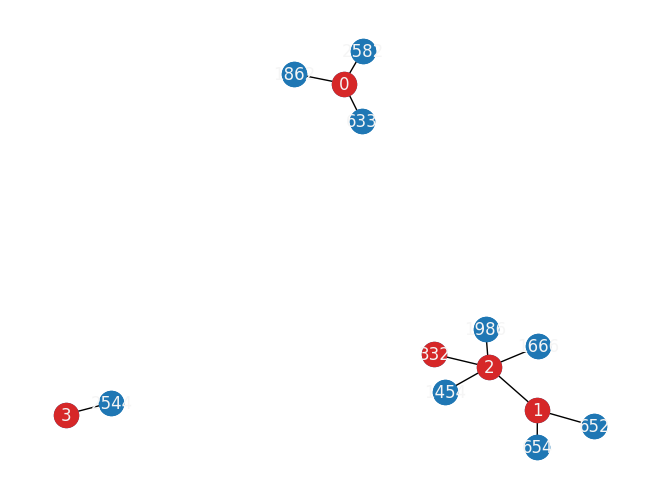

In [14]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx

edges = [(s,t) for s,t in zip(edge_example[0], edge_example[1])]
print(edges, len(edges), sep='\n')

## 노드를 두 개의 커뮤니티(두 부분 집합)로 분리
comm_0 = node_example[:5] ## 빨간색
comm_1 = node_example[5:] ## 파란색
print(comm_0, comm_1)

comm_G = nx.Graph()
comm_G.add_edges_from(edges) 
pos = nx.spring_layout(comm_G, seed=2023) ## positions for all nodes 
nx.draw(comm_G, pos=pos, with_labels=True, font_color="whitesmoke") 
nx.draw_networkx_nodes(comm_G, pos, comm_0, node_color="tab:red")
nx.draw_networkx_nodes(comm_G, pos, comm_1, node_color="tab:blue")
comm_G.add_nodes_from(comm_0, community=0)
comm_G.add_nodes_from(comm_1, community=1)
comm_G.nodes(data=True)

### 2-1. `Community CN (C.N. Soundarajan-Hopcroft score)`
- "the common neighbors Soundarajan-Hopcroft score of nodes $x$ and $y$"
    - $CCN(x,y):=|N(x)\cap N(y)|+\sum_{v\in N(x)\cap N(y)}f(v)$, where $f(v)= 1$ if $v\in N(x)\cap N(y)$ and 0, otherwise  
  
    - 공통 이웃의 수 $=|N(x)\cap N(y)| = CN(x,y)$  
  
    - 공통 이웃이 같은 커뮤니티에 속하는지의 여부 $=\sum_{v\in N(x)\cap N(y)}f(v)$ 
  
- `cn_soundarajan_hopcroft(G, ebunch=None, community='community')`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.cn_soundarajan_hopcroft.html

In [15]:
cn_s_h = list(nx.cn_soundarajan_hopcroft(comm_G))
cn_s_h = sorted(cn_s_h, key=lambda x: x[2], reverse=True)
for u,v,csh in cn_s_h:
    print(f"({u}, {v}) -> {csh}")

(1, 332) -> 2
(1, 1986) -> 1
(1, 1666) -> 1
(1, 1454) -> 1
(2, 652) -> 1
(2, 654) -> 1
(1666, 1986) -> 1
(1666, 332) -> 1
(1666, 1454) -> 1
(1986, 332) -> 1
(1986, 1454) -> 1
(1862, 2582) -> 1
(1862, 633) -> 1
(652, 654) -> 1
(332, 1454) -> 1
(2582, 633) -> 1
(0, 1) -> 0
(0, 2) -> 0
(0, 3) -> 0
(0, 1986) -> 0
(0, 1666) -> 0
(0, 652) -> 0
(0, 332) -> 0
(0, 654) -> 0
(0, 1454) -> 0
(0, 2544) -> 0
(1, 3) -> 0
(1, 1862) -> 0
(1, 2544) -> 0
(1, 2582) -> 0
(1, 633) -> 0
(2, 3) -> 0
(2, 1862) -> 0
(2, 2544) -> 0
(2, 2582) -> 0
(2, 633) -> 0
(1666, 3) -> 0
(1666, 1862) -> 0
(1666, 652) -> 0
(1666, 654) -> 0
(1666, 2544) -> 0
(1666, 2582) -> 0
(1666, 633) -> 0
(1986, 3) -> 0
(1986, 1862) -> 0
(1986, 652) -> 0
(1986, 654) -> 0
(1986, 2544) -> 0
(1986, 2582) -> 0
(1986, 633) -> 0
(3, 1862) -> 0
(3, 652) -> 0
(3, 332) -> 0
(3, 654) -> 0
(3, 1454) -> 0
(3, 2582) -> 0
(3, 633) -> 0
(1862, 652) -> 0
(1862, 332) -> 0
(1862, 1454) -> 0
(1862, 654) -> 0
(1862, 2544) -> 0
(652, 332) -> 0
(652, 1454) -> 0

### 2-2. `Community RA (Community Resource Allocation)`
- "the Resource Allocation Soundarajan-Hopcroft score of nodes $x$ and $y$"
    - $CRA(x,y):=\sum_{v\in N(x)\cap N(y)}\frac{f(v)}{|N(v)|}$, where $f(v)= 1$ if $v\in N(x)\cap N(y)$ and 0, otherwise  
  
    - 기존 RA 와 비슷하나, 분자에 1 대신 $f(v)$ -> 커뮤니티에 속했는지의 여부도 헤아림 
  
- `ra_index_soundarajan_hopcroft(G, ebunch=None, community='community')`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.ra_index_soundarajan_hopcroft.html#networkx.algorithms.link_prediction.ra_index_soundarajan_hopcroft

In [16]:
ra_s_h = list(nx.ra_index_soundarajan_hopcroft(comm_G))
ra_s_h = sorted(ra_s_h, key=lambda x: x[2], reverse=True)
for u,v,rsh in ra_s_h:
    print(f"({u}, {v}) -> {rsh}")

(1, 332) -> 0.2
(0, 1) -> 0
(0, 2) -> 0
(0, 3) -> 0
(0, 1986) -> 0
(0, 1666) -> 0
(0, 652) -> 0
(0, 332) -> 0
(0, 654) -> 0
(0, 1454) -> 0
(0, 2544) -> 0
(1, 1986) -> 0
(1, 1666) -> 0
(1, 3) -> 0
(1, 1862) -> 0
(1, 1454) -> 0
(1, 2544) -> 0
(1, 2582) -> 0
(1, 633) -> 0
(2, 3) -> 0
(2, 1862) -> 0
(2, 652) -> 0
(2, 654) -> 0
(2, 2544) -> 0
(2, 2582) -> 0
(2, 633) -> 0
(1666, 1986) -> 0
(1666, 3) -> 0
(1666, 1862) -> 0
(1666, 652) -> 0
(1666, 332) -> 0
(1666, 654) -> 0
(1666, 1454) -> 0
(1666, 2544) -> 0
(1666, 2582) -> 0
(1666, 633) -> 0
(1986, 3) -> 0
(1986, 1862) -> 0
(1986, 652) -> 0
(1986, 332) -> 0
(1986, 654) -> 0
(1986, 1454) -> 0
(1986, 2544) -> 0
(1986, 2582) -> 0
(1986, 633) -> 0
(3, 1862) -> 0
(3, 652) -> 0
(3, 332) -> 0
(3, 654) -> 0
(3, 1454) -> 0
(3, 2582) -> 0
(3, 633) -> 0
(1862, 652) -> 0
(1862, 332) -> 0
(1862, 1454) -> 0
(1862, 654) -> 0
(1862, 2544) -> 0
(1862, 2582) -> 0
(1862, 633) -> 0
(652, 332) -> 0
(652, 654) -> 0
(652, 1454) -> 0
(652, 2544) -> 0
(652, 2582) ->